In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch

In [3]:
prms_speed = pd.read_csv('_prms/exp_speed.csv')
prms_accuracy = pd.read_csv('_prms/exp_accuracy.csv')
data = pd.read_csv('../../_Data/Study1.csv', 
                   index_col=0).reset_index(drop=True)
data['rt']/=1000
data['Duration']/=1000

data['g_contrast'] = data['contrast']//10*10

data_speed = data[data.condition == 'speed'].reset_index(drop=True)
data_accuracy = data[data.condition == 'accuracy'].reset_index(drop=True)

In [4]:
prms_speed

,sbj,b0,lambda,delta0,delta1,t0,sigma,mean_z,std_z,G2,BIC
0,S10_epo,1.063003,1.938202,2.657076,0.439041,0.165521,0.262037,0.164701,0.049439,-2099.923018,-2062.020030
1,S11_epo,0.771870,0.617656,2.912777,0.521739,0.285249,0.300659,0.291594,0.076257,-953.819458,-915.873304
2,S12_epo,1.012519,1.116185,1.847281,0.239883,0.228548,0.439728,0.253327,0.099739,-600.807454,-562.893646
3,S13_epo,2.036355,1.214511,4.636427,0.854471,0.217123,0.267751,0.217273,0.069727,-1487.807390,-1449.861237
4,S14_epo,1.832008,3.000000,3.532660,0.554088,0.193642,0.278603,0.191765,0.056666,-2201.543232,-2163.597078
5,S15_epo,0.996833,2.026865,2.990758,0.561567,0.211144,0.323186,0.208444,0.063075,-1646.230332,-1608.349044
6,S16_epo,1.426600,1.984503,3.205220,0.587271,0.178617,0.348635,0.177056,0.069428,-1668.756986,-1630.832376
7,S17_epo,1.250859,1.183141,2.748728,0.534367,0.209913,0.357581,0.207032,0.077328,-1028.527605,-990.581451
8,S18_epo,0.734446,0.622519,2.778419,0.589607,0.209426,0.401266,0.212032,0.078819,-936.589982,-898.643828
9,S19_epo,0.557634,0.254822,1.780444,0.350519,0.198789,0.556757,0.191164,0.083277,-851.649559,-813.735751


In [5]:
RT = np.array([])
Cont = np.array([])
SBJ = np.array([])

for i in tqdm(range(prms_speed.sbj.unique().shape[0])):
    sbj = prms_speed.sbj.unique()[i]
    b0 = prms_speed['b0'].values[i]
    lamda = prms_speed['lambda'].values[i]
    delta0 = prms_speed['delta0'].values[i]
    delta1 = prms_speed['delta1'].values[i]
    t0 = prms_speed['t0'].values[i]
    
    ub = lambda t: b0 * np.exp(-lamda*t)
    lb = lambda t: -1*ub(t) 
    
    sbj_data = data_speed[data_speed['participant']==sbj].reset_index(drop=True)
    contrast = sbj_data.contrast.values
    
    rt = []
    
    for c in contrast:
        delta = delta0 - delta1*np.log(c)
#         delta = delta0 - delta1*np.log((c-2.5)/(c+2.5))
        rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))
    
    RT = np.concatenate([RT, rt])
    Cont = np.concatenate([Cont, contrast])
    SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])
    
pred_speed = pd.DataFrame({'sbj': SBJ,
                           'rt': np.abs(RT),
                           'accuracy': RT>0,
                           'contrast': Cont,
                           'g_contrast': Cont//10*10})        

100%|███████████████████████████████████████████| 26/26 [00:44<00:00,  1.73s/it]


In [6]:
RT = np.array([])
Cont = np.array([])
SBJ = np.array([])

for i in tqdm(range(prms_accuracy.sbj.unique().shape[0])):
    sbj = prms_accuracy.sbj.unique()[i]
    b0 = prms_accuracy['b0'].values[i]
    lamda = prms_accuracy['lambda'].values[i]
    delta0 = prms_accuracy['delta0'].values[i]
    delta1 = prms_accuracy['delta1'].values[i]
    t0 = prms_accuracy['t0'].values[i]
    
    ub = lambda t: b0 * np.exp(-lamda*t)
    lb = lambda t: -1*ub(t) 
    
    sbj_data = data_accuracy[data_accuracy['participant']==sbj].reset_index(drop=True)
    contrast = sbj_data.contrast.values
    
    rt = []
    
    for c in contrast:
        delta = delta0 - delta1*np.log(c)
#         delta = delta0 - delta1*np.log((c-2.5)/(c+2.5))
        rt.append(simulate_CDDM(ub, lb, delta, ndt=t0))
    
    RT = np.concatenate([RT, rt])
    Cont = np.concatenate([Cont, contrast])
    SBJ = np.concatenate([SBJ, np.array([sbj]*len(rt))])
    
pred_accuracy = pd.DataFrame({'sbj': SBJ,
                              'rt': np.abs(RT),
                              'accuracy': RT>0,
                              'contrast': Cont,
                              'g_contrast': Cont//10*10})   

100%|███████████████████████████████████████████| 26/26 [01:20<00:00,  3.10s/it]


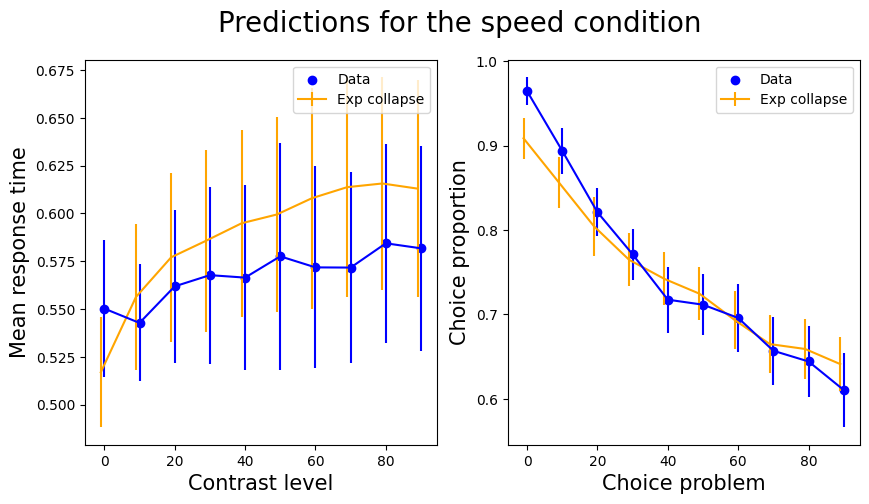

In [7]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Predictions for the speed condition', fontsize=20)

plt.subplot(121)

err = scipy.stats.t.ppf(0.975, 80)
temp = pred_speed.groupby(by=['sbj', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=-1 + pred_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=pred_speed.groupby(by='g_contrast')['rt'].mean(),
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             label='Exp collapse', c='orange');

temp = data_speed.groupby(by=['participant', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_speed.groupby(by='g_contrast')['rt'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c='blue');
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['rt'].mean(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time', fontsize=15)
plt.legend();

plt.subplot(122)
temp = pred_speed.groupby(by=['sbj', 'g_contrast'])['accuracy'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=-1 + pred_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=pred_speed.groupby(by='g_contrast')['accuracy'].mean(),
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             label='Exp collapse', c='orange');

temp = data_speed.groupby(by=['participant', 'g_contrast'])['correct'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c='blue');
plt.scatter(x=data_speed.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_speed.groupby(by='g_contrast')['correct'].mean(), 
            c='blue', label='Data');

plt.xlabel('Choice problem', fontsize=15)
plt.ylabel('Choice proportion', fontsize=15)
plt.legend();

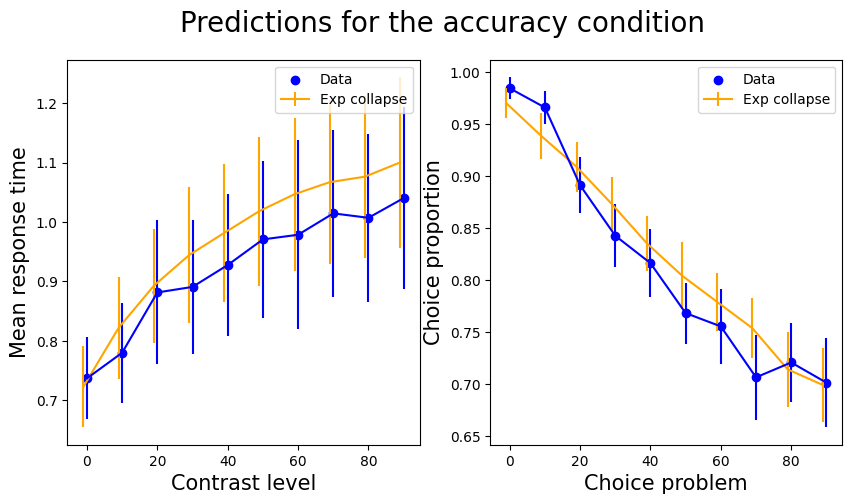

In [8]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Predictions for the accuracy condition', fontsize=20)

plt.subplot(121)

err = scipy.stats.t.ppf(0.975, 80)
temp = pred_accuracy.groupby(by=['sbj', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=-1 + pred_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=pred_accuracy.groupby(by='g_contrast')['rt'].mean(),
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             label='Exp collapse', c='orange');

temp = data_accuracy.groupby(by=['participant', 'g_contrast'])['rt'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_accuracy.groupby(by='g_contrast')['rt'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c='blue');
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['rt'].mean(), 
            c='blue', label='Data');
plt.xlabel('Contrast level', fontsize=15)
plt.ylabel('Mean response time', fontsize=15)
plt.legend();

plt.subplot(122)
temp = pred_accuracy.groupby(by=['sbj', 'g_contrast'])['accuracy'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=-1 + pred_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=pred_accuracy.groupby(by='g_contrast')['accuracy'].mean(),
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             label='Exp collapse', c='orange');

temp = data_accuracy.groupby(by=['participant', 'g_contrast'])['correct'].mean()
temp = pd.DataFrame(np.array([temp[i].values for i in data.participant.unique()]), 
                    columns=[j*10 for j in range(10)])
plt.errorbar(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
             y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
             yerr=err*np.array([temp[i].std()/np.sqrt(26) for i in [j*10 for j in range(10)]]), 
             c='blue');
plt.scatter(x=data_accuracy.groupby(by='g_contrast')['g_contrast'].mean(), 
            y=data_accuracy.groupby(by='g_contrast')['correct'].mean(), 
            c='blue', label='Data');

plt.xlabel('Choice problem', fontsize=15)
plt.ylabel('Choice proportion', fontsize=15)
plt.legend();